In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
#from sklearn.externals import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed

import tensorflow as tf
from tensorflow.random import set_seed 
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
#tf.logging.set_verbosity(tf.logging.ERROR)

from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

seed(10)
set_seed(10)

In [4]:
train = pd.read_csv('/content/drive/MyDrive/02_코랩/02_ai팩토리/공기압축기_이상_판단/train_data.csv')
test = pd.read_csv('/content/drive/MyDrive/02_코랩/02_ai팩토리/공기압축기_이상_판단/test_data.csv')
answer_sample = pd.read_csv('/content/drive/MyDrive/02_코랩/02_ai팩토리/공기압축기_이상_판단/answer_sample.csv')

In [5]:
train.shape

(2463, 8)

In [6]:
test.shape

(7389, 8)

In [7]:
title_mapping = {0: 30, 4:30, 5:30, 6:30, 7:30, 1:20, 2:10, 3:50}
train['hp'] = train['type'].map(title_mapping)
test['hp'] = test['type'].map(title_mapping)
train = train.drop('type', axis = 1)
test = test.drop('type', axis = 1)

In [8]:
train

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,hp
0,1.59,41.00,0.7,20.53,1680.0,58.67,2.93,30
1,2.97,59.28,0.7,38.40,3142.0,74.91,3.75,30
2,1.91,45.29,0.7,24.73,2023.0,62.48,3.12,30
3,2.37,51.33,0.7,30.63,2506.0,67.84,3.39,30
4,1.90,45.21,0.7,24.65,2017.0,62.41,3.12,30
...,...,...,...,...,...,...,...,...
2458,2.28,50.20,0.7,29.53,2416.0,66.84,3.34,30
2459,2.04,46.94,0.7,26.34,2155.0,63.94,3.20,30
2460,1.19,35.74,0.7,15.39,1259.0,53.99,2.70,30
2461,1.21,36.00,0.7,15.64,1280.0,54.22,2.71,30


In [9]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)

In [10]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print(X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print(X_test.shape)

(2463, 1, 8)
(7389, 1, 8)


In [11]:
def autoencoder_model(X):
  inputs = Input(shape =(X.shape[1], X.shape[2]))
  L1 = LSTM(140, activation='relu', return_sequences=True,
            kernel_regularizer=regularizers.l2(0.00))(inputs)
  L2 = LSTM(70, activation='relu', return_sequences=False)(L1)
  L3 = RepeatVector(X.shape[1])(L2)
  L4 = LSTM(70, activation='relu', return_sequences=True)(L3)
  L5 = LSTM(140, activation='relu', return_sequences=True)(L4)
  output = TimeDistributed(Dense(X.shape[2]))(L5)
  model = Model(inputs = inputs, outputs = output)
  return model

In [12]:
model = autoencoder_model(X_train)
model.compile(optimizer ='adam', loss='mae')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 8)]            0         
                                                                 
 lstm (LSTM)                 (None, 1, 140)            83440     
                                                                 
 lstm_1 (LSTM)               (None, 70)                59080     
                                                                 
 repeat_vector (RepeatVector  (None, 1, 70)            0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 1, 70)             39480     
                                                                 
 lstm_3 (LSTM)               (None, 1, 140)            118160    
                                                             

In [13]:
nb_epochs = 100
batch_size = 20
history = model.fit(X_train, X_train, epochs = nb_epochs, batch_size = batch_size,
                    validation_split = 0.05).history

Epoch 1/100
117/117 [==============================] - 13s 51ms/step - loss: 0.1804 - val_loss: 0.0489
Epoch 2/100
117/117 [==============================] - 4s 31ms/step - loss: 0.0756 - val_loss: 0.0289
Epoch 3/100
117/117 [==============================] - 3s 24ms/step - loss: 0.0593 - val_loss: 0.0102
Epoch 4/100
117/117 [==============================] - 3s 28ms/step - loss: 0.0375 - val_loss: 0.0081
Epoch 5/100
117/117 [==============================] - 4s 32ms/step - loss: 0.0154 - val_loss: 0.0044
Epoch 6/100
117/117 [==============================] - 3s 29ms/step - loss: 0.0081 - val_loss: 0.0036
Epoch 7/100
117/117 [==============================] - 1s 12ms/step - loss: 0.0068 - val_loss: 0.0046
Epoch 8/100
117/117 [==============================] - 1s 13ms/step - loss: 0.0053 - val_loss: 0.0028
Epoch 9/100
117/117 [==============================] - 1s 13ms/step - loss: 0.0057 - val_loss: 0.0022
Epoch 10/100
117/117 [==============================] - 1s 13ms/step - loss: 0.00

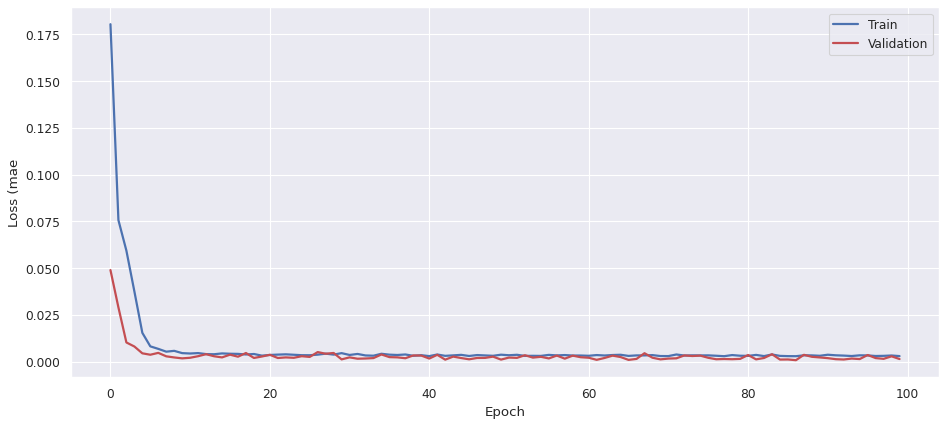

In [14]:
fig, ax = plt.subplots(figsize = (14, 6), dpi = 80)
ax.plot(history["loss"], "b", label = "Train", linewidth = 2)
ax.plot(history["val_loss"], "r", label = "Validation", linewidth = 2)
ax.set_ylabel("Loss (mae")
ax.set_xlabel("Epoch")
ax.legend(loc="upper right")

77/77 [==============================] - 1s 5ms/step


<ipython-input-15-ae0ed4690d5d>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scored["Loss_mae"], bins = 20, kde = True, color = "blue");


(0.0, 0.1)

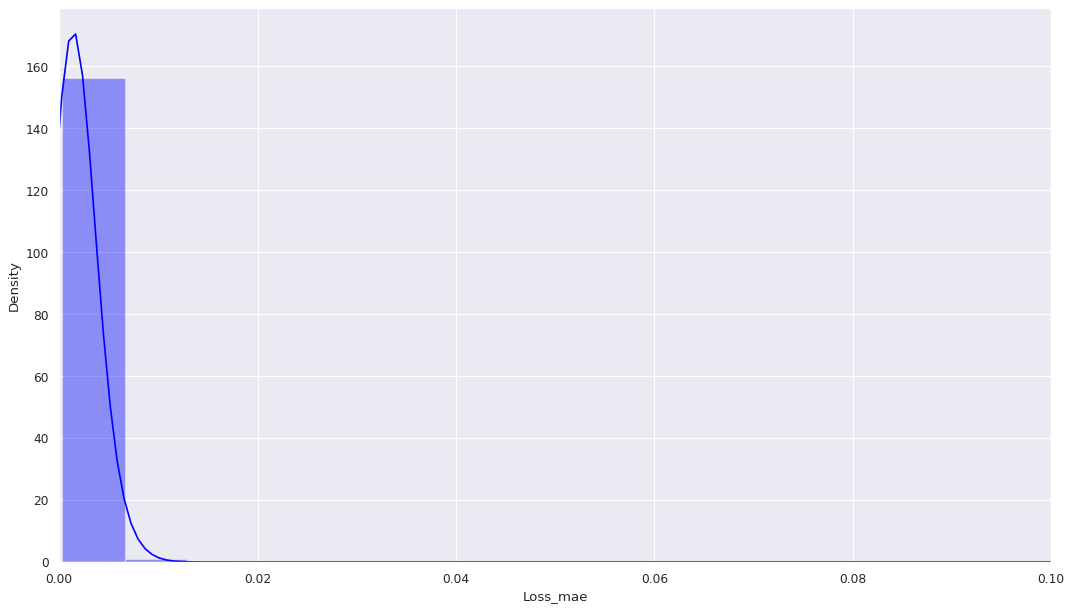

In [15]:
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns = train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored["Loss_mae"] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi = 80)
sns.distplot(scored["Loss_mae"], bins = 20, kde = True, color = "blue");
plt.xlim([0.0,0.1])

In [16]:
print("anomaly threshold = {}".format(np.percentile(scored, 100)))
threshold = np.percentile(scored, 99)

X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index = test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored["Loss_mae"] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored["Threshold"] = threshold
scored["Anomaly"] = scored["Loss_mae"] > scored["Threshold"]
scored.head()

# 정상 0, 비정상 1

anomaly threshold = 0.1266411173718195
231/231 [==============================] - 1s 5ms/step


,Loss_mae,Threshold,Anomaly
0,0.001226,0.007066,False
1,0.001187,0.007066,False
2,0.001448,0.007066,False
3,0.001064,0.007066,False
4,0.001311,0.007066,False


In [17]:
scored["Anomaly"].value_counts()

False    7048
True      341
Name: Anomaly, dtype: int64

In [18]:
answer_sample["label"] = scored["Anomaly"]
answer_sample.head()
answer_sample["label"].value_counts()

False    7048
True      341
Name: label, dtype: int64

In [19]:
answer_sample.to_csv("submission10.csv", index=False)
submission10 = pd.read_csv("submission10.csv")
submission10["label"].value_counts()

False    7048
True      341
Name: label, dtype: int64